C:\Users\Benja\AppData\Roaming\Python\Python313\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


TESTING DIFFERENT SCENARIOS
Test Case 1: Soil moisture = 30%, Temperature = 35°C, Time = 7 AM (morning)
Water Sprinkling Level: 84.44%

Test Case 2: Soil moisture = 30%, Temperature = 35°C, Time = 1 PM (midday)
Water Sprinkling Level: 50.00%

Test Case 3: Soil moisture = 50%, Temperature = 25°C, Time = 7 PM (evening)
Water Sprinkling Level: 50.00%

Test Case 4: Soil moisture = 75%, Temperature = 20°C, Time = 10 PM (night)
Water Sprinkling Level: 13.33%


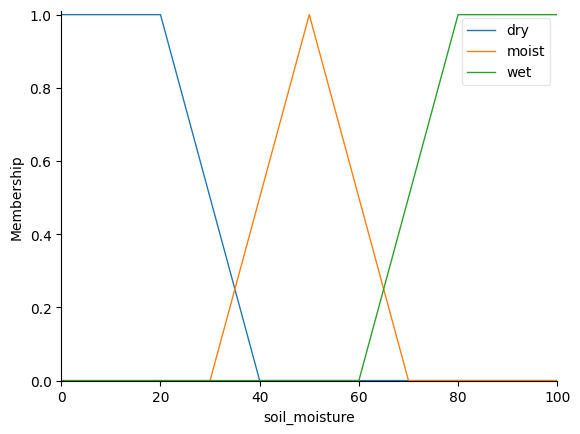

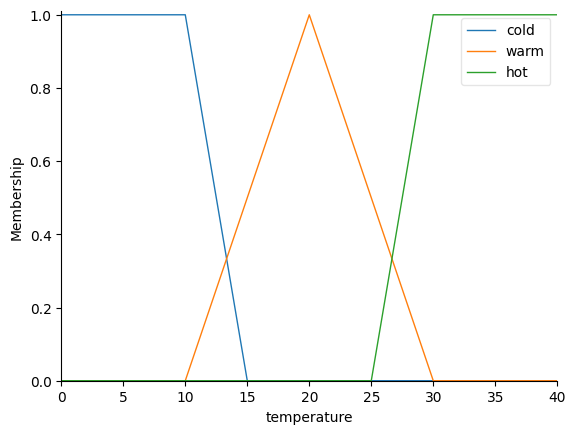

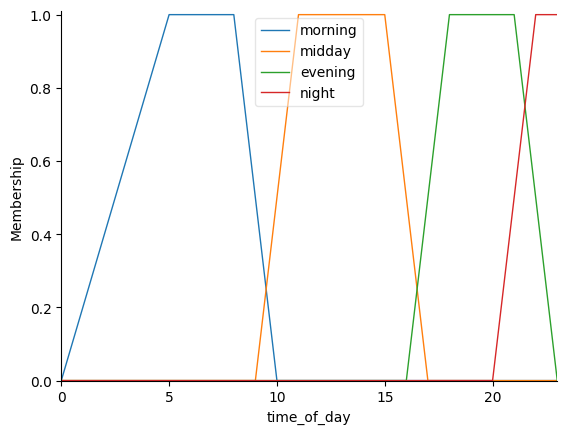

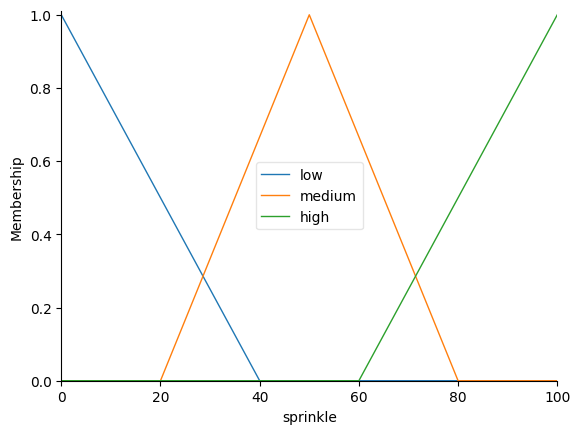

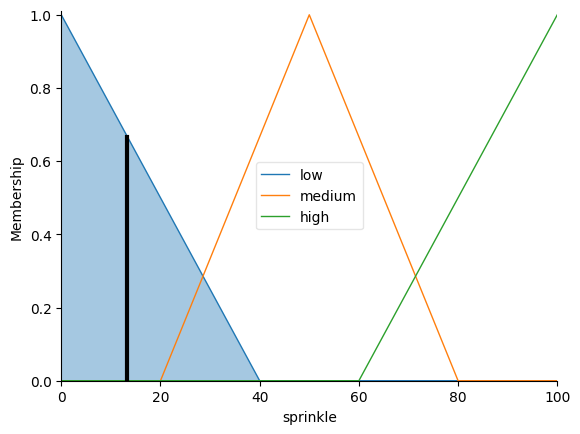

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Input variables
soil_moisture = ctrl.Antecedent(np.arange(0, 101, 1), 'soil_moisture')
temperature = ctrl.Antecedent(np.arange(0, 41, 1), 'temperature')
time_of_day = ctrl.Antecedent(np.arange(0, 24, 1), 'time_of_day')  # 0-23 hours

# Output variable
sprinkle = ctrl.Consequent(np.arange(0, 101, 1), 'sprinkle')

# Soil moisture membership functions
soil_moisture['dry'] = fuzz.trapmf(soil_moisture.universe, [0, 0, 20, 40])
soil_moisture['moist'] = fuzz.trimf(soil_moisture.universe, [30, 50, 70])
soil_moisture['wet'] = fuzz.trapmf(soil_moisture.universe, [60, 80, 100, 100])

# Temperature membership functions
temperature['cold'] = fuzz.trapmf(temperature.universe, [0, 0, 10, 15])
temperature['warm'] = fuzz.trimf(temperature.universe, [10, 20, 30])
temperature['hot'] = fuzz.trapmf(temperature.universe, [25, 30, 40, 40])

# Time of day membership functions
time_of_day['morning'] = fuzz.trapmf(time_of_day.universe, [0, 5, 8, 10])  # 5am-10am
time_of_day['midday'] = fuzz.trapmf(time_of_day.universe, [9, 11, 15, 17])  # 11am-5pm
time_of_day['evening'] = fuzz.trapmf(time_of_day.universe, [16, 18, 21, 23])  # 6pm-9pm
time_of_day['night'] = fuzz.trapmf(time_of_day.universe, [20, 22, 24, 24])  # 10pm-12am and 0am-5am

# Sprinkle level membership functions
sprinkle['low'] = fuzz.trimf(sprinkle.universe, [0, 0, 40])
sprinkle['medium'] = fuzz.trimf(sprinkle.universe, [20, 50, 80])
sprinkle['high'] = fuzz.trimf(sprinkle.universe, [60, 100, 100])

# Define fuzzy rules with time of day
# Base rules from soil moisture and temperature
rule1 = ctrl.Rule(soil_moisture['dry'] & temperature['hot'] & time_of_day['morning'], sprinkle['high'])
rule2 = ctrl.Rule(soil_moisture['dry'] & temperature['hot'] & time_of_day['evening'], sprinkle['high'])
rule3 = ctrl.Rule(soil_moisture['dry'] & temperature['hot'] & time_of_day['midday'], sprinkle['medium'])  # Reduce during midday to prevent evaporation
rule4 = ctrl.Rule(soil_moisture['dry'] & temperature['warm'] & ~time_of_day['midday'], sprinkle['medium'])
rule5 = ctrl.Rule(soil_moisture['dry'] & temperature['warm'] & time_of_day['midday'], sprinkle['low'])
rule6 = ctrl.Rule(soil_moisture['dry'] & temperature['cold'], sprinkle['medium'])

rule7 = ctrl.Rule(soil_moisture['moist'] & temperature['hot'] & time_of_day['midday'], sprinkle['medium'])
rule8 = ctrl.Rule(soil_moisture['moist'] & temperature['hot'] & time_of_day['midday'], sprinkle['low'])
rule9 = ctrl.Rule(soil_moisture['moist'] & temperature['warm'] & ~time_of_day['midday'], sprinkle['medium'])
rule10 = ctrl.Rule(soil_moisture['moist'] & temperature['warm'] & time_of_day['midday'], sprinkle['low'])
rule11 = ctrl.Rule(soil_moisture['moist'] & temperature['cold'], sprinkle['low'])

# Night rules - reduce watering at night for most conditions
rule12 = ctrl.Rule(time_of_day['night'] & ~soil_moisture['dry'], sprinkle['low'])
rule13 = ctrl.Rule(time_of_day['night'] & soil_moisture['dry'] & temperature['hot'], sprinkle['medium'])

# Wet soil rule - always low regardless of other factors
rule14 = ctrl.Rule(soil_moisture['wet'], sprinkle['low'])

# Create control system
rules = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, 
         rule11, rule12, rule13, rule14]
sprinkler_ctrl = ctrl.ControlSystem(rules)
sprinkler = ctrl.ControlSystemSimulation(sprinkler_ctrl)

# Visualize the membership functions
soil_moisture.view()
temperature.view()
time_of_day.view()
sprinkle.view()

# Test cases with time of day
print("=" * 50)
print("TESTING DIFFERENT SCENARIOS")
print("=" * 50)

# Test case 1: Dry soil, hot temperature, morning
sprinkler.input['soil_moisture'] = 30
sprinkler.input['temperature'] = 35
sprinkler.input['time_of_day'] = 7  # 7 AM
sprinkler.compute()
print(f"Test Case 1: Soil moisture = 30%, Temperature = 35°C, Time = 7 AM (morning)")
print(f"Water Sprinkling Level: {sprinkler.output['sprinkle']:.2f}%")

# Test case 2: Dry soil, hot temperature, midday
sprinkler.input['soil_moisture'] = 30
sprinkler.input['temperature'] = 35
sprinkler.input['time_of_day'] = 13  # 1 PM
sprinkler.compute()
print(f"\nTest Case 2: Soil moisture = 30%, Temperature = 35°C, Time = 1 PM (midday)")
print(f"Water Sprinkling Level: {sprinkler.output['sprinkle']:.2f}%")

# Test case 3: Moist soil, warm temperature, evening
sprinkler.input['soil_moisture'] = 50
sprinkler.input['temperature'] = 25
sprinkler.input['time_of_day'] = 19  # 7 PM
sprinkler.compute()
print(f"\nTest Case 3: Soil moisture = 50%, Temperature = 25°C, Time = 7 PM (evening)")
print(f"Water Sprinkling Level: {sprinkler.output['sprinkle']:.2f}%")

# Test case 4: Wet soil, any temperature, night
sprinkler.input['soil_moisture'] = 75
sprinkler.input['temperature'] = 20
sprinkler.input['time_of_day'] = 22  # 10 PM
sprinkler.compute()
print(f"\nTest Case 4: Soil moisture = 75%, Temperature = 20°C, Time = 10 PM (night)")
print(f"Water Sprinkling Level: {sprinkler.output['sprinkle']:.2f}%")

# Visualize the result for the last test case
sprinkle.view(sim=sprinkler)
plt.show()